<a href="https://colab.research.google.com/github/raulbenitez/PIB/blob/main/filtrat_imatges.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tècniques de filtrat d'imatges

## 1. Filtres estadístics

### Load test images:

Adding noise to images:

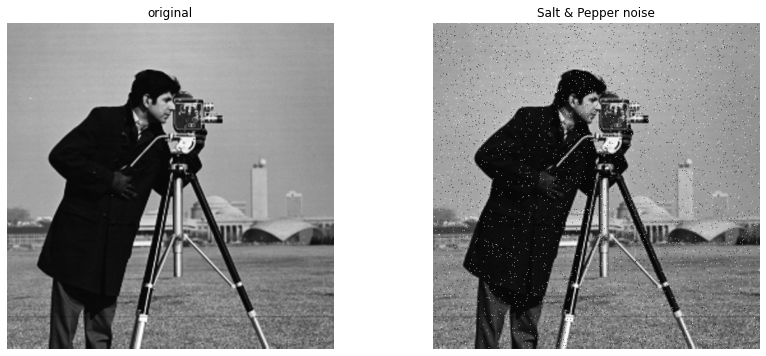

In [ ]:
%matplotlib inline 

import matplotlib.pyplot as plt
import numpy as np 
from skimage import data
from skimage import img_as_ubyte

img = data.camera()

## Noisy image: Add some noise by randomly setting some pixels to 0 or 255 (salt and pepper noise)
noise = np.random.random(img.shape) # uniform random numbers between 0 and 1
noisy_image = img_as_ubyte(data.camera())
noisy_image[noise > 0.99] = 255 
noisy_image[noise < 0.01] = 0


def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(14, 6), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')
    
plot_comparison(img,noisy_image,'Salt & Pepper noise')
plt.savefig('Noisy.png')

### Median filters:

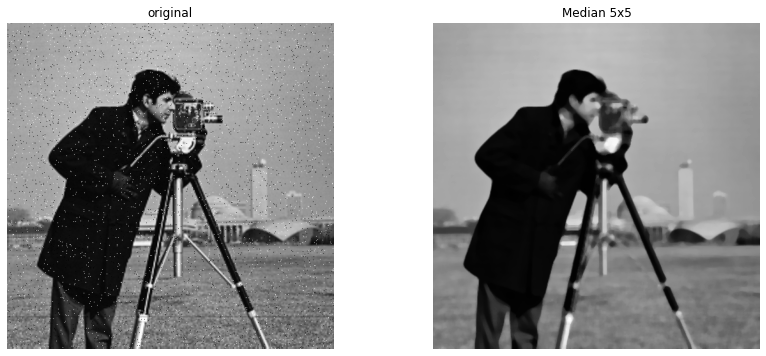

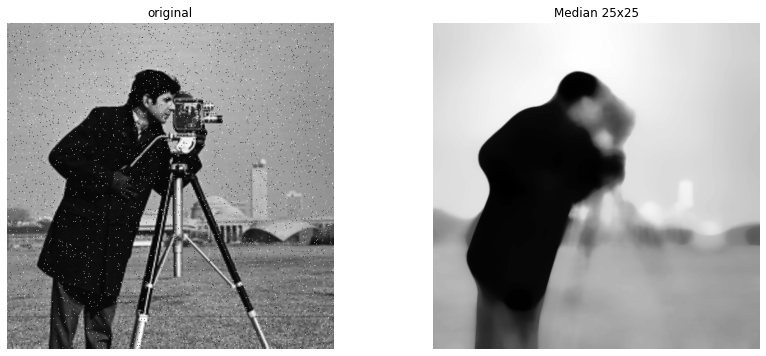

In [ ]:
from skimage.morphology import disk
from skimage.filters import median

img = img_as_ubyte(noisy_image)
sel5 = disk(5) # structuring element disk radius 5 pixels
img_med5x5 = median(img, sel5)
plot_comparison(img,img_med5x5,'Median 5x5')
plt.savefig('median.png')

sel25 = disk(25)
img_med25x25 = median(img, sel25)
plot_comparison(img,img_med25x25,'Median 25x25')

### Filtre de promitjat local:

Add Gaussian noise to the image:

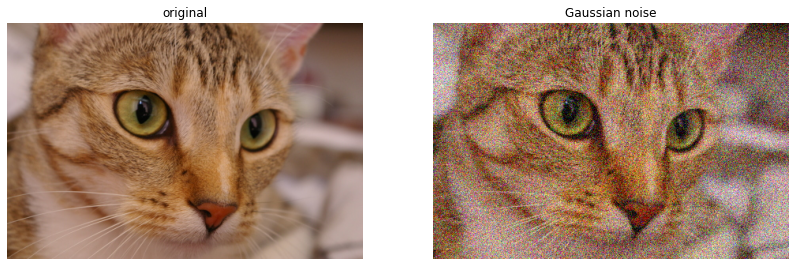

In [ ]:
import matplotlib.pyplot as plt
import numpy as np 
from skimage import data
from skimage import img_as_ubyte

from skimage import data, img_as_float
from skimage.util import random_noise


img = img_as_float(data.chelsea())
sigma = 0.15
noisy_image_normal = random_noise(img, var=sigma**2)

plot_comparison(img,noisy_image_normal,'Gaussian noise')

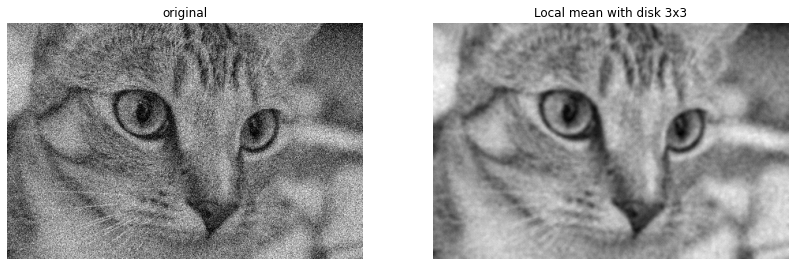

In [ ]:
from skimage.filters import rank
from skimage.color import rgb2gray

img = img_as_ubyte(rgb2gray(noisy_image_normal))

selem = disk(3) # structuring element 
img_locmed = rank.mean(img, selem=selem)
plot_comparison(img,img_locmed,'Local mean with disk 3x3')
plt.savefig('Local_mean.png')

## 2. Filtres espacials per convolució:

### La convolució 2D:

In [ ]:
import numpy as np 
I = np.array([[0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 1, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0],
             [0, 0, 0, 0, 0, 0, 0]])
h = np.array([[1,2,3],[4,5,6],[7,8,9]])

from scipy import ndimage
Iconv = ndimage.convolve(I, h, mode='constant', cval=0.0)
Iconv

array([[0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 2, 3, 0, 0],
       [0, 0, 4, 5, 6, 0, 0],
       [0, 0, 7, 8, 9, 0, 0],
       [0, 0, 0, 0, 0, 0, 0]])

### Filtre gaussià:

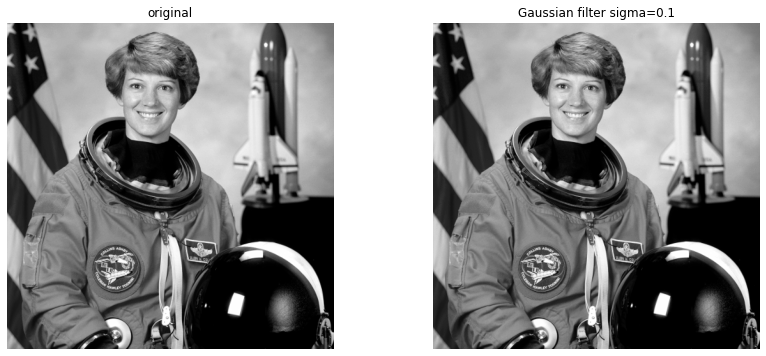

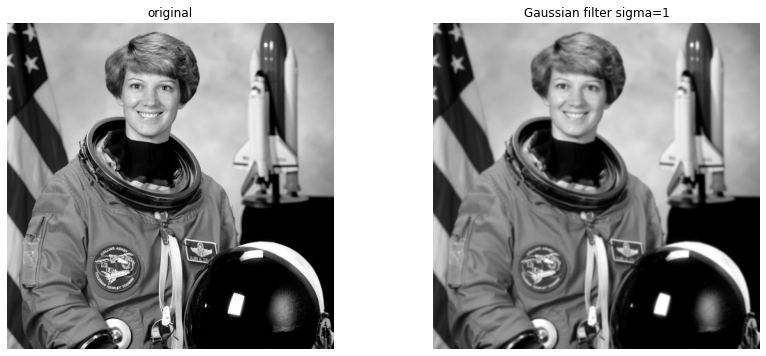

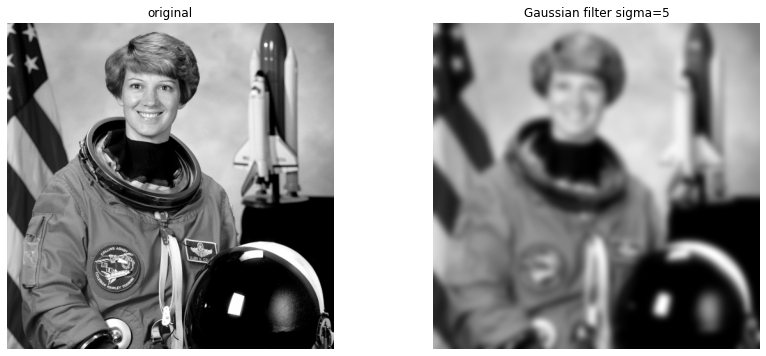

In [ ]:
from skimage import data
from skimage.filters import gaussian
from skimage.color import rgb2gray

img = data.astronaut()
img = rgb2gray(img)

img_f = gaussian(img, sigma=0.1)
plot_comparison(img,img_f, 'Gaussian filter sigma=0.1')
plt.savefig('gaussian.png')


img_f = gaussian(img, sigma=1)
plot_comparison(img,img_f, 'Gaussian filter sigma=1')


img_f = gaussian(img, sigma=5)
plot_comparison(img,img_f, 'Gaussian filter sigma=5')

### Detecció de contorns: 

Sobel and Roberts gradient operators

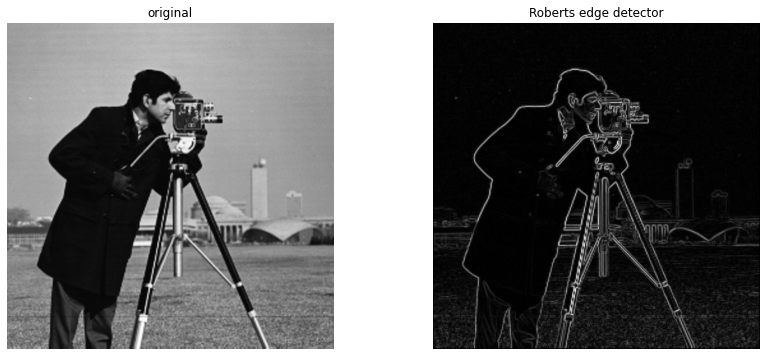

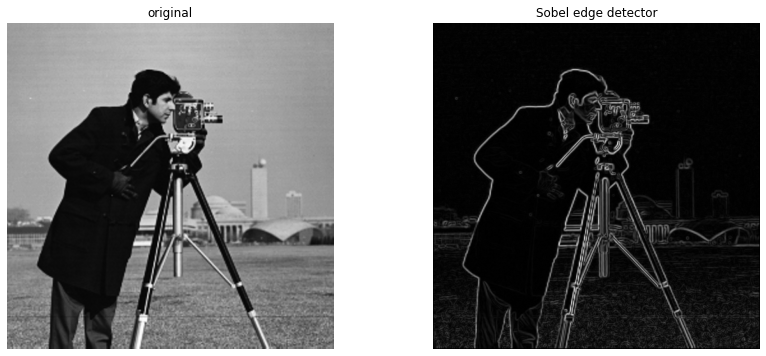

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

from skimage.data import camera
from skimage.filters import roberts, sobel

image = camera()

edge_roberts = roberts(image)
plot_comparison(image,edge_roberts, 'Roberts edge detector')
plt.savefig('roberts_edges.png')


edge_sobel = sobel(image)
plot_comparison(image,edge_sobel, 'Sobel edge detector')

### Enhancing contours: Laplacian filters: 

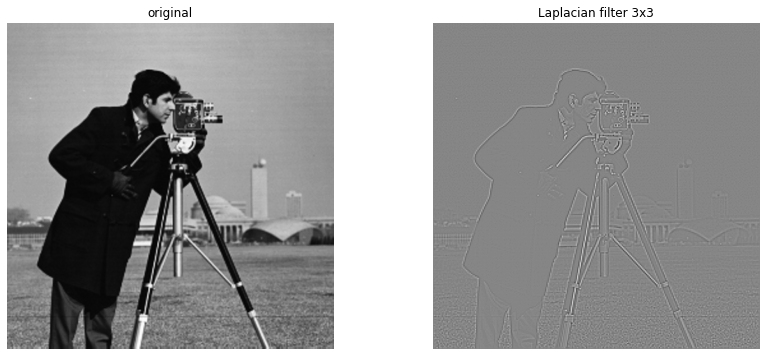

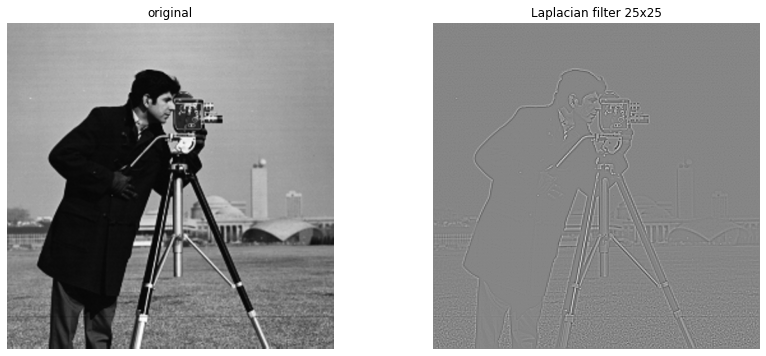

In [ ]:
from skimage import data
from skimage.filters import laplace
from skimage.color import rgb2gray

img_f = laplace(image, 3)
plot_comparison(image,img_f, 'Laplacian filter 3x3')
plt.savefig('laplacian.png')


img_f = laplace(image, 25)
plot_comparison(image,img_f, 'Laplacian filter 25x25')

## 3. Filtres en el domini de la freqüència:

Using the FFT and the Convolution theorem:


First we obtain the 2D Discrete Fourier Transform of the image (FFT algorithm):


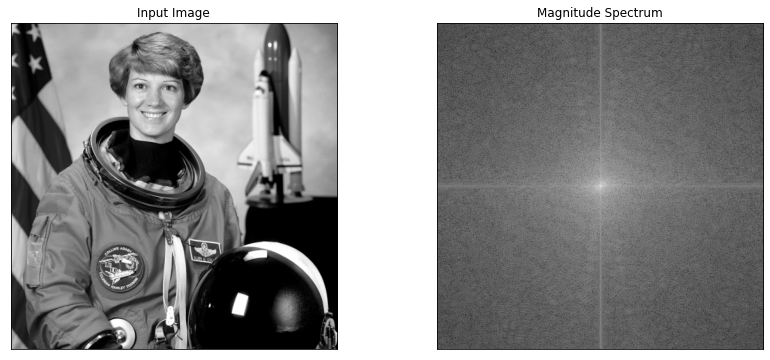

In [ ]:
import numpy as np
from skimage import data
from skimage.color import rgb2gray
from matplotlib import pyplot as plt

img = data.astronaut()
img = rgb2gray(img)


f = np.fft.fft2(img) # Discrete Fourier Transform using FFT algorithm
fshift = np.fft.fftshift(f) # Shift to have zero frequency (origin) at the center of the image
magnitude_spectrum = 20*np.log(np.abs(fshift)) # Logarithmic scale for better visualization of the differences in powert spectrum

fig = plt.figure(figsize=(14, 6))
plt.subplot(121),plt.imshow(img, cmap = 'gray')
plt.title('Input Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122),plt.imshow(magnitude_spectrum, cmap = 'gray')
plt.title('Magnitude Spectrum'), plt.xticks([]), plt.yticks([])
plt.savefig('frequency.png')
plt.show()


### High-pass filter: 

Just remove the regions with lower frequencies near the origin of the DFT. Then obtain the filtered image by applying the inverse discrete Fourier transform to the result:

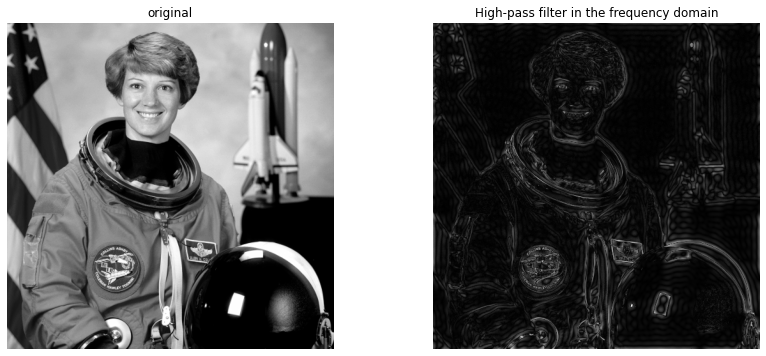

In [ ]:
rows, cols = img.shape
crow,ccol = np.int(rows/2) , np.int(cols/2)
fshift[crow-30:crow+30, ccol-30:ccol+30] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

plot_comparison(img,img_back, 'High-pass filter in the frequency domain')

### Low-pass filter: 

Just remove the regions with higher frequencies far from the origin of the DFT. Then obtain the filtered image by applying the inverse discrete Fourier transform to the result:

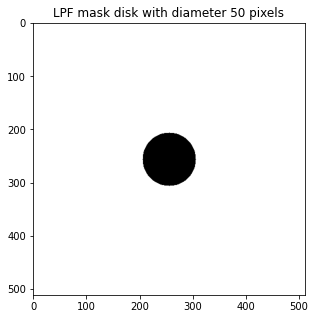

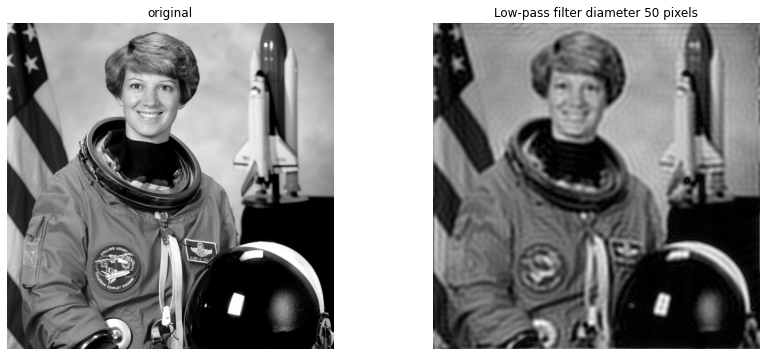

In [ ]:
nrows, ncols = img.shape
row, col = np.ogrid[:nrows, :ncols]
cnt_row, cnt_col = nrows / 2, ncols / 2
disk_diameter = 50
outer_disk_mask = ((row - cnt_row)**2 + (col - cnt_col)**2 > (disk_diameter)**2)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

fshift[outer_disk_mask] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

fig = plt.figure(figsize=(5,5))
plt.imshow(outer_disk_mask,cmap=plt.cm.gray)
plt.title('LPF mask disk with diameter {} pixels'.format(disk_diameter))
plt.show()

plot_comparison(img,img_back, 'Low-pass filter diameter {} pixels'.format(disk_diameter))

Let's increase the disk diameter and therefore the frequencies that are kept in the filter: Since we remove less high-frequency content of the spactrum, the filtered image retains more detail than in the previous example:

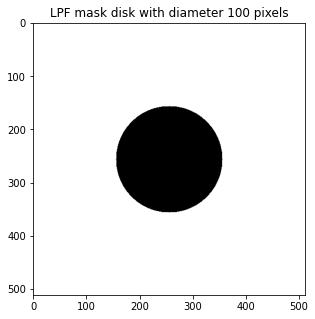

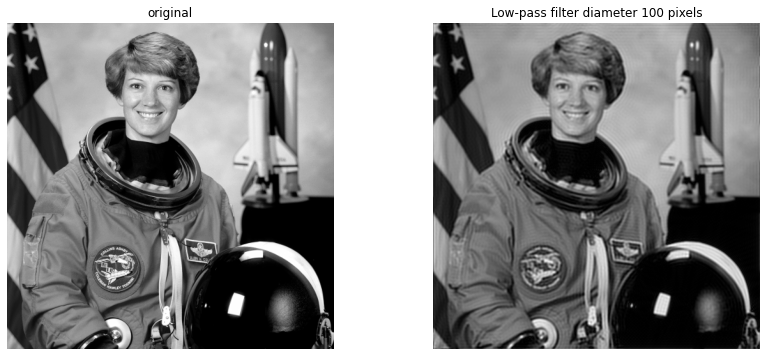

In [ ]:
disk_diameter = 100
outer_disk_mask = ((row - cnt_row)**2 + (col - cnt_col)**2 > (disk_diameter)**2)

f = np.fft.fft2(img)
fshift = np.fft.fftshift(f)
magnitude_spectrum = 20*np.log(np.abs(fshift))

fshift[outer_disk_mask] = 0
f_ishift = np.fft.ifftshift(fshift)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)

fig = plt.figure(figsize=(5,5))
plt.imshow(outer_disk_mask,cmap=plt.cm.gray)
plt.title('LPF mask disk with diameter {} pixels'.format(disk_diameter))
plt.show()
plot_comparison(img,img_back, 'Low-pass filter diameter {} pixels'.format(disk_diameter))

## 4. Esqueletonització: 

Algorisme de Zhang 




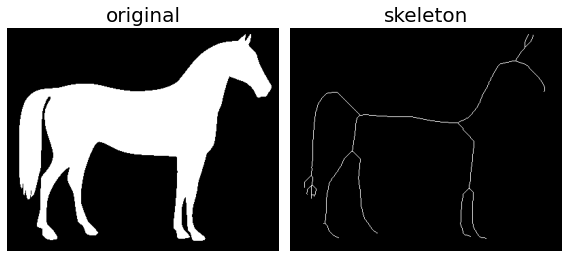

In [14]:
from skimage.morphology import skeletonize
from skimage import data
import matplotlib.pyplot as plt
from skimage.util import invert

# Invert the horse image
image = invert(data.horse())

# perform skeletonization
skeleton = skeletonize(image)

# display results
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4),
                         sharex=True, sharey=True)

ax = axes.ravel()

ax[0].imshow(image, cmap=plt.cm.gray)
ax[0].axis('off')
ax[0].set_title('original', fontsize=20)

ax[1].imshow(skeleton, cmap=plt.cm.gray)
ax[1].axis('off')
ax[1].set_title('skeleton', fontsize=20)

fig.tight_layout()
plt.show()